In [197]:
import os
import ray

In [75]:
import sys; sys.path.append("..")
import warnings; warnings.filterwarnings("ignore")
from dotenv import load_dotenv; load_dotenv()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

Unable to poll TPU GCE metadata: HTTPConnectionPool(host='metadata.google.internal', port=80): Max retries exceeded with url: /computeMetadata/v1/instance/attributes/accelerator-type (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002363D5DA350>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Failed to detect number of TPUs: [WinError 3] The system cannot find the path specified: '/dev/vfio'


2024-07-22 12:20:54,679	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.14
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


In [77]:
ray.cluster_resources()

{'memory': 386587854.0,
 'node:127.0.0.1': 1.0,
 'object_store_memory': 193293926.0,
 'CPU': 8.0,
 'node:__internal_head__': 1.0,
 'GPU': 1.0}

In [78]:
# Workers (1 g4dn.xlarge)
num_workers = 1
resources_per_worker={"CPU": 6, "GPU": 0}

In [79]:
# Setup workers
for _ in range(num_workers):
    ray.remote(resources=resources_per_worker)

In [80]:
ray.cluster_resources()

{'memory': 386587854.0,
 'node:127.0.0.1': 1.0,
 'object_store_memory': 193293926.0,
 'CPU': 8.0,
 'node:__internal_head__': 1.0,
 'GPU': 1.0}

In [81]:
import os
from dotenv import load_dotenv

# Load the .env file
load_dotenv()

# Storage
EFS_DIR = f"/efs/shared_storage/nlp/{os.getenv('GITHUB_USERNAME')}"
print(EFS_DIR)

/efs/shared_storage/nlp/Vipulbhansali


# Data ingestion

In [82]:
import pandas as pd

# Data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/Vipulbhansali/END-TO-END-NLP-PROJECT/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [83]:
# Value counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

# Data splitting

In [84]:
from sklearn.model_selection import train_test_split

# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [85]:
# Train value counts
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [86]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

# Exploratory Data Analysis (EDA)

In [87]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

In [88]:
# Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

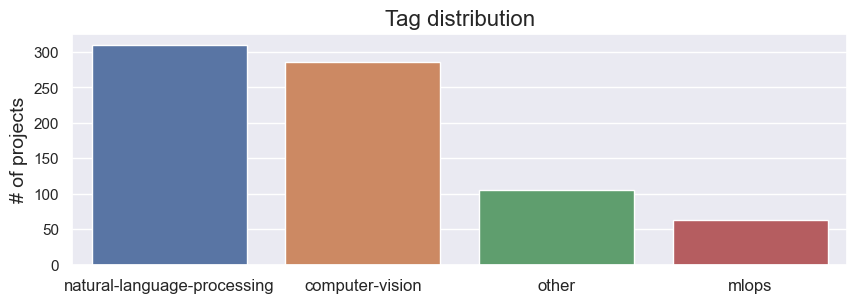

In [89]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=12)
plt.title("Tag distribution", fontsize=16)
plt.ylabel("# of projects", fontsize=14)
plt.show()

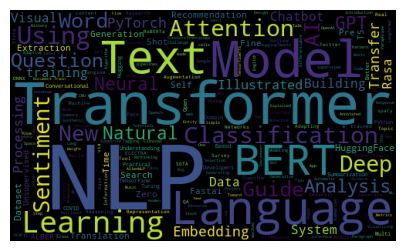

In [90]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

# Data Preprocessing

In [91]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re


# Feature engineering
df["text"] = df.title + " " + df.description

#clean text
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vipul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [92]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [93]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


In [94]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


## Label encoding

In [95]:

# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [96]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [97]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

## Tokenizer

Next we'll encode our text as well. Instead of using a random dictionary, we'll use a tokenizer that was used for a pretrained LLM (scibert) to tokenize our text. We'll be fine-tuning this exact model later when we train our model.

In [98]:
import numpy as np
from transformers import BertTokenizer

# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [99]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [100]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2], dtype=int64)}

In [101]:
# combining all the steps into 1 function

def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [102]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1, 0, 3, 1

In [103]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1, 0, 3, 1

# Distributed preprocessing
The main issue with our approach above is that we're limited by our single machine in terms how much data our dataframe can hold and that we can preprocess. With the increasing trend in ML for larger unstructured datasets and larger models (LLMs), we can quickly outgrow our single machine constraints and will need to go distributed.

In [104]:
from nlp.data import stratify_split
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [105]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

# https://docs.ray.io/en/latest/data/api/input_output.html input/output link for ray

2024-07-22 12:21:27,223	INFO read_api.py:406 -- To satisfy the requested parallelism of 16, each read task output is split into 16 smaller blocks.
2024-07-22 12:21:27,263	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-07-22 12:21:27,263	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(16) 1:   0%|          | 0/256 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/256 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 428,
  'created_on': datetime.datetime(2020, 4, 10, 4, 57, 53),
  'title': 'AiLight: Automatic  Highlighting Using BERT',
  'description': 'Automatically highlight pdfs using BERT embeddings and clustering.\nhttps://anishthite.github.io/ailight',
  'tag': 'natural-language-processing'}]

In [106]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

#https://docs.ray.io/en/latest/data/api/doc/ray.data.grouped_data.GroupedData.map_groups.html
# https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map_batches.html

2024-07-22 12:21:33,661	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-07-22 12:21:33,661	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(16) 1:   0%|          | 0/256 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/256 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [107]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2024-07-22 12:21:36,664	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2024-07-22 12:21:36,670	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(16) 1:   0%|          | 0/256 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/256 [00:00<?, ?it/s]

- limit=1 12:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2024-07-22 12:21:41,448	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2024-07-22 12:21:41,467	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(16) 1:   0%|          | 0/256 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/256 [00:00<?, ?it/s]

- Aggregate 12:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 13:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 14:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(<lambda>) 15:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

In [108]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(preprocess, fn_kwargs={"class_to_index": class_to_index}, batch_format="pandas")
sample_ds.show(1)

2024-07-22 12:21:45,053	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2024-07-22 12:21:45,055	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(16) 1:   0%|          | 0/256 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(preprocess) 12:   0%|          | 0/256 [00:00<?, ?it/s]

- limit=1 13:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

(MapBatches(preprocess) pid=13696) c:\Users\Vipul\miniconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess) pid=13696)   warnings.warn(


{'ids': array([  102,  2158,  2556,  6021,  1968, 13749,  1904, 12662, 14288,
       30111,  9999,   164,  2040,  1968, 13749,  1904,  2556,  6021,
        6076,  1516, 24660, 30131,   103,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'targets': 0}


# Benchmarking

We'll first set up some functions that will help us achieve complete reproducibility

In [179]:
pip install openai==0.27.8 tqdm==4.65.0 -q

Note: you may need to restart the kernel to use updated packages.


In [180]:
import openai
openai.api_key = os.getenv("OPENAI_API_KEY")

In [181]:
import pandas as pd

# Load training data
DATASET_LOC = "https://raw.githubusercontent.com/Vipulbhansali/END-TO-END-NLP-PROJECT/main/datasets/dataset.csv"
train_df = pd.read_csv(DATASET_LOC)
train_df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [182]:
# Load inference dataset
HOLDOUT_LOC = "https://raw.githubusercontent.com/Vipulbhansali/END-TO-END-NLP-PROJECT/main/datasets/holdout.csv"
test_df = pd.read_csv(HOLDOUT_LOC)

In [183]:
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn.metrics import precision_recall_fscore_support
import time
from tqdm import tqdm

In [184]:
# Query OpenAI endpoint
system_content = "you only answer in rhymes"  # system content (behavior)
assistant_content = ""  # assistant content (context)
user_content = "how are you"  # user content (message)
response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": system_content},
        {"role": "assistant", "content": assistant_content},
        {"role": "user", "content": user_content},
    ],
)
print (response.to_dict()["choices"][0].to_dict()["message"]["content"])

#https://platform.openai.com/docs/quickstart

I'm here to assist, don't you fear,
Feeling great, thanks for asking, dear!


let's create a function that can predict tags for a given sample.

In [185]:
def get_tag(model, system_content="", assistant_content="", user_content=""):
    try:
        # Get response from OpenAI
        response = openai.ChatCompletion.create(
            model=model,
            messages=[
                {"role": "system", "content": system_content},
                {"role": "assistant", "content": assistant_content},
                {"role": "user", "content": user_content},
            ],
        )
        predicted_tag = response.to_dict()["choices"][0].to_dict()["message"]["content"]
        return predicted_tag

    except (openai.error.ServiceUnavailableError, openai.error.APIError) as e:
        return None

In [186]:
# Get tag
model = "gpt-3.5-turbo"
system_context = f"""
    You are a NLP prediction service that predicts the label given an input's title and description.
    You must choose between one of the following labels for each input: {tags}.
    Only respond with the label name and nothing else.
    """
assistant_content = ""
user_context = "Transfer learning with transformers: Using transformers for transfer learning on text classification tasks."
tag = get_tag(model=model, system_content=system_context, assistant_content=assistant_content, user_content=user_context)
print (tag)

natural-language-processing


In [187]:
# List of dicts w/ {title, description} (just the first 3 samples for now)
samples = test_df[["title", "description"]].to_dict(orient="records")[:3]
samples

[{'title': 'Diffusion to Vector',
  'description': 'Reference implementation of Diffusion2Vec (Complenet 2018) built on Gensim and NetworkX. '},
 {'title': 'Graph Wavelet Neural Network',
  'description': 'A PyTorch implementation of "Graph Wavelet Neural Network" (ICLR 2019) '},
 {'title': 'Capsule Graph Neural Network',
  'description': 'A PyTorch implementation of "Capsule Graph Neural Network" (ICLR 2019).'}]

In [188]:
def get_predictions(inputs, model, system_content, assistant_content=""):
    y_pred = []
    for item in tqdm(inputs):
        # Convert item dict to string
        user_content = str(item)

        # Get prediction
        predicted_tag = get_tag(
            model=model, system_content=system_content,
            assistant_content=assistant_content, user_content=user_content)

        # If error, try again after pause (repeatedly until success)
        while predicted_tag is None:
            time.sleep(30)  # could also do exponential backoff
            predicted_tag = get_tag(
                model=model, system_content=system_content,
                assistant_content=assistant_content, user_content=user_content)

        # Add to list of predictions
        y_pred.append(predicted_tag)

    return y_pred

In [158]:
# Get predictions for a list of inputs
get_predictions(inputs=samples, model=model, system_content=system_context)

100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


['natural-language-processing',
 'natural-language-processing',
 'natural-language-processing']

Next we'll define a function that can clean our predictions in the event that it's not the proper format or has hallucinated a tag outside of our expected tags.

In [189]:
def clean_predictions(y_pred, tags, default="other"):
    for i, item in enumerate(y_pred):
        if item not in tags:  # hallucinations
            y_pred[i] = default
        if item.startswith("'") and item.endswith("'"):  # GPT 4 likes to places quotes
            y_pred[i] = item[1:-1]
    return y_pred

In [190]:
def plot_tag_dist(y_true, y_pred):
    # Distribution of tags
    true_tag_freq = dict(Counter(y_true))
    pred_tag_freq = dict(Counter(y_pred))
    df_true = pd.DataFrame({"tag": list(true_tag_freq.keys()), "freq": list(true_tag_freq.values()), "source": "true"})
    df_pred = pd.DataFrame({"tag": list(pred_tag_freq.keys()), "freq": list(pred_tag_freq.values()), "source": "pred"})
    df = pd.concat([df_true, df_pred], ignore_index=True)

    # Plot
    plt.figure(figsize=(10, 3))
    plt.title("Tag distribution", fontsize=14)
    ax = sns.barplot(x="tag", y="freq", hue="source", data=df)
    ax.set_xticklabels(list(true_tag_freq.keys()), rotation=0, fontsize=8)
    plt.legend()
    plt.show()

In [191]:
def evaluate(test_df, model, system_content, assistant_content, tags):
    # Predictions
    y_test = test_df.tag.to_list()
    test_samples = test_df[["title", "description"]].to_dict(orient="records")
    y_pred = get_predictions(
        inputs=test_samples, model=model,
        system_content=system_content, assistant_content=assistant_content)
    y_pred = clean_predictions(y_pred=y_pred, tags=tags)

    # Performance
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    print(json.dumps(performance, indent=2))
    plot_tag_dist(y_true=y_test, y_pred=y_pred)
    return y_pred, performance

# Benchmarks
Now we're ready to start benchmarking our different LLMs with different context.

In [192]:
y_pred = {"zero_shot": {}, "few_shot": {}}
performance = {"zero_shot": {}, "few_shot": {}}

# Zero-shot learning
We'll start with zero-shot learning which involves providing the model with the system_content that tells it how to behave but no examples of the behavior.

In [164]:
system_content = f"""
    You are a NLP prediction service that predicts the label given an input's title and description. 
    You must choose between one of the following labels for each input: {tags}. 
    Only respond with the label name and nothing else.
    """

100%|██████████| 191/191 [02:31<00:00,  1.26it/s]


{
  "precision": 0.8211470852035387,
  "recall": 0.8429319371727748,
  "f1": 0.815312962389355
}


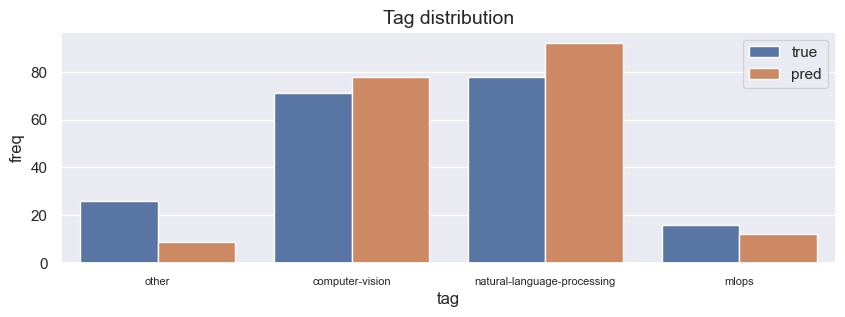

In [138]:
# Zero-shot with GPT 3.5
method = "zero_shot"
model = "gpt-3.5-turbo"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content,
    assistant_content="", tags=tags)

100%|██████████| 191/191 [03:18<00:00,  1.04s/it]


{
  "precision": 0.921179832384021,
  "recall": 0.9214659685863874,
  "f1": 0.9199061601519627
}


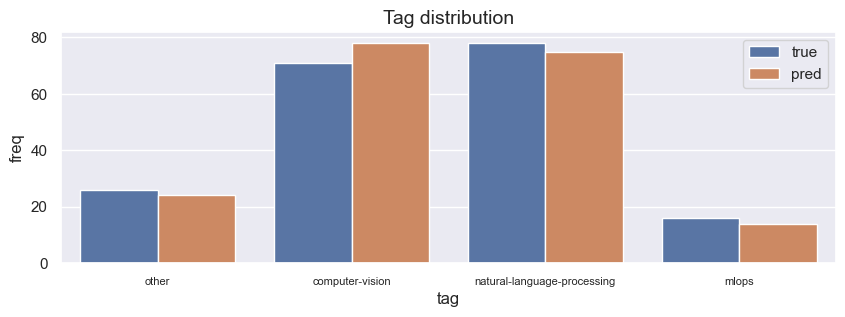

In [139]:
# Zero-shot with GPT 4
method = "zero_shot"
model = "gpt-4-0613"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content,
    assistant_content="", tags=tags)

# Few-shot learning
Now, we'll be adding a assistant_context with a few samples from our training data for each class. The intuition here is that we're giving the model a few examples (few-shot learning) of what each class looks like so that it can learn to generalize better.

In [193]:
# Create additional context with few samples from each class
num_samples = 2
additional_context = []
cols_to_keep = ["title", "description", "tag"]
for tag in tags:
    samples = train_df[cols_to_keep][train_df.tag == tag][:num_samples].to_dict(orient="records")
    additional_context.extend(samples)
additional_context

[{'title': 'Comparison between YOLO and RCNN on real world videos',
  'description': 'Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.',
  'tag': 'computer-vision'},
 {'title': 'Show, Infer & Tell: Contextual Inference for Creative Captioning',
  'description': 'The beauty of the work lies in the way it architects the fundamental idea that humans look at the overall image and then individual pieces of it.\n',
  'tag': 'computer-vision'},
 {'title': 'Pytest Board',
  'description': 'Continuous pytest runner with awesome visualization.',
  'tag': 'mlops'},
 {'title': 'Debugging Neural Networks with PyTorch and W&B',
  'description': 'A closer look at debugging common issues when training neural networks.',
  'tag': 'mlops'},
 {'title': 'Rethinking Batch Normalization in Transformers',
  'description': 'We found that NLP batch statistics exhibit large variance throughout training, which leads to poor BN performance.',
  'tag': 'na

In [194]:
# Add additional context
assistant_content = f"""Here are some examples with the correct labels: {additional_context}"""
print (assistant_content)

Here are some examples with the correct labels: [{'title': 'Comparison between YOLO and RCNN on real world videos', 'description': 'Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.', 'tag': 'computer-vision'}, {'title': 'Show, Infer & Tell: Contextual Inference for Creative Captioning', 'description': 'The beauty of the work lies in the way it architects the fundamental idea that humans look at the overall image and then individual pieces of it.\n', 'tag': 'computer-vision'}, {'title': 'Pytest Board', 'description': 'Continuous pytest runner with awesome visualization.', 'tag': 'mlops'}, {'title': 'Debugging Neural Networks with PyTorch and W&B', 'description': 'A closer look at debugging common issues when training neural networks.', 'tag': 'mlops'}, {'title': 'Rethinking Batch Normalization in Transformers', 'description': 'We found that NLP batch statistics exhibit large variance throughout training, which leads to poor BN p

100%|██████████| 191/191 [02:36<00:00,  1.22it/s]


{
  "precision": 0.845818210996041,
  "recall": 0.8638743455497382,
  "f1": 0.843104651184607
}


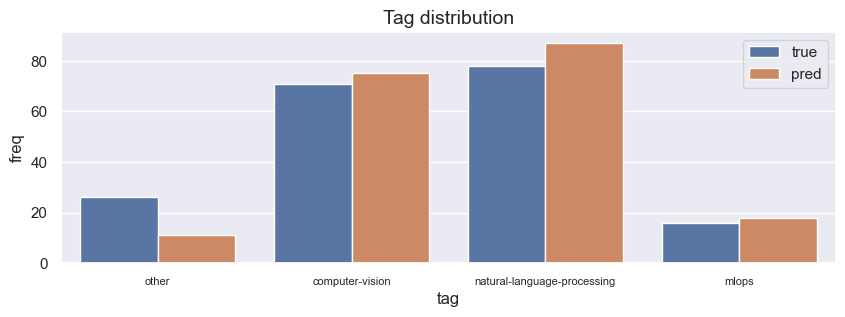

In [167]:
# Few-shot with GPT 3.5
method = "few_shot"
model = "gpt-3.5-turbo"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content,
    assistant_content=assistant_content, tags=tags)

In [ ]:
test_subset_df = test_df.head(20)
# Few-shot with GPT-4
method = "few_shot"
model = "gpt-4-0613"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_subset_df, model=model, system_content=system_content,
    assistant_content=assistant_content, tags=tags)